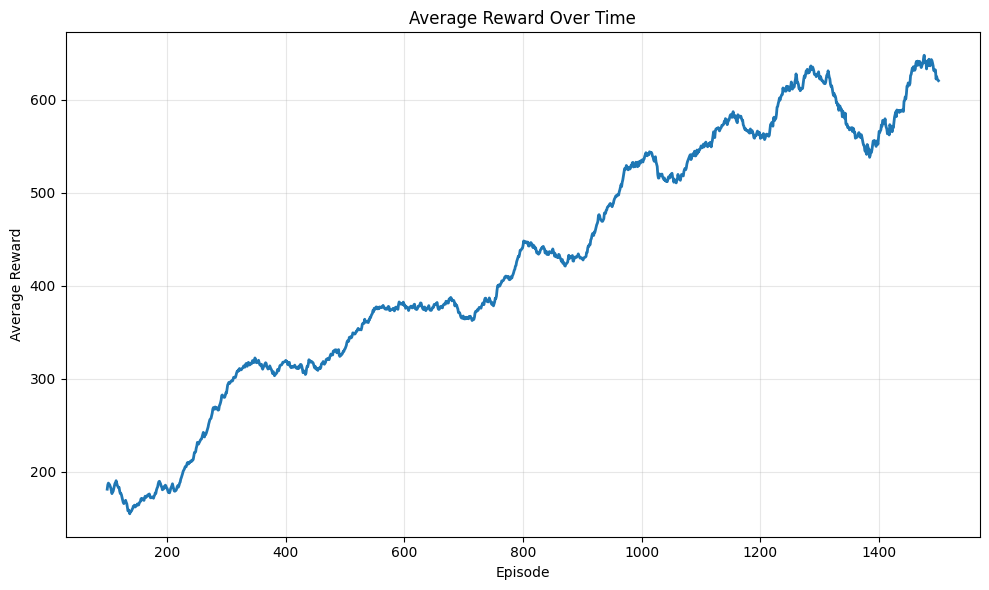

In [17]:
import re
import matplotlib.pyplot as plt

# Read the file
with open('../logs/rew/avg_reward_norm.txt', 'r') as f:
    lines = f.readlines()

# Parse episodes and rewards
episodes = []
rewards = []

for line in lines:
    match = re.search(r'Episode (\d+); Average Reward: ([\d.]+)', line)
    if match:
        episodes.append(int(match.group(1)))
        rewards.append(float(match.group(2)))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(episodes, rewards, linewidth=2)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

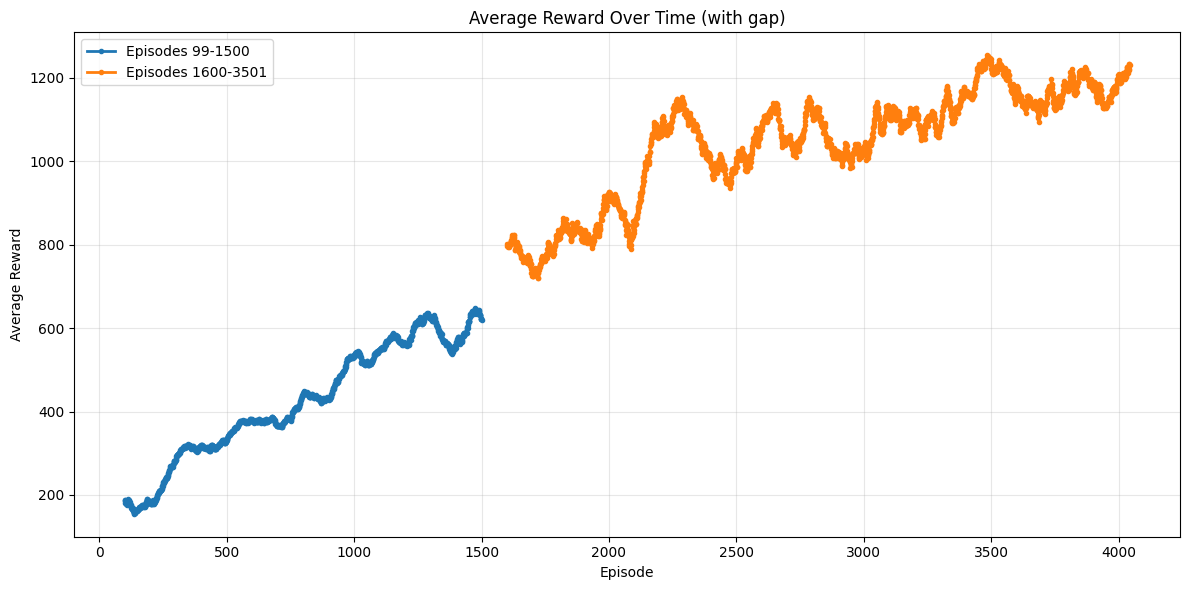

In [18]:
import re
import matplotlib.pyplot as plt

def read_and_parse(filename):
    """Read file and parse episodes and rewards"""
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    episodes = []
    rewards = []
    
    for line in lines:
        match = re.search(r'Episode (\d+); Average Reward: ([\d.]+)', line)
        if match:
            episodes.append(int(match.group(1)))
            rewards.append(float(match.group(2)))
    
    return episodes, rewards

# Read both files
episodes1, rewards1 = read_and_parse('../logs/rew/avg_reward_norm.txt')
episodes2, rewards2 = read_and_parse('../logs/rew/avg_reward_norm_2.txt')  # Change filename

# Offset second file episodes: add 1501 to shift them to 1600-3501
episodes2_offset = [ep + 1501 for ep in episodes2]

# Combine the data
all_episodes = episodes1 + episodes2_offset
all_rewards = rewards1 + rewards2

# Plot
plt.figure(figsize=(12, 6))
# Plot each batch separately to prevent connecting line
plt.plot(episodes1, rewards1, linewidth=2, marker='o', markersize=3, label='Episodes 99-1500')
plt.plot(episodes2_offset, rewards2, linewidth=2, marker='o', markersize=3, label='Episodes 1600-3501')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward Over Time (with gap)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

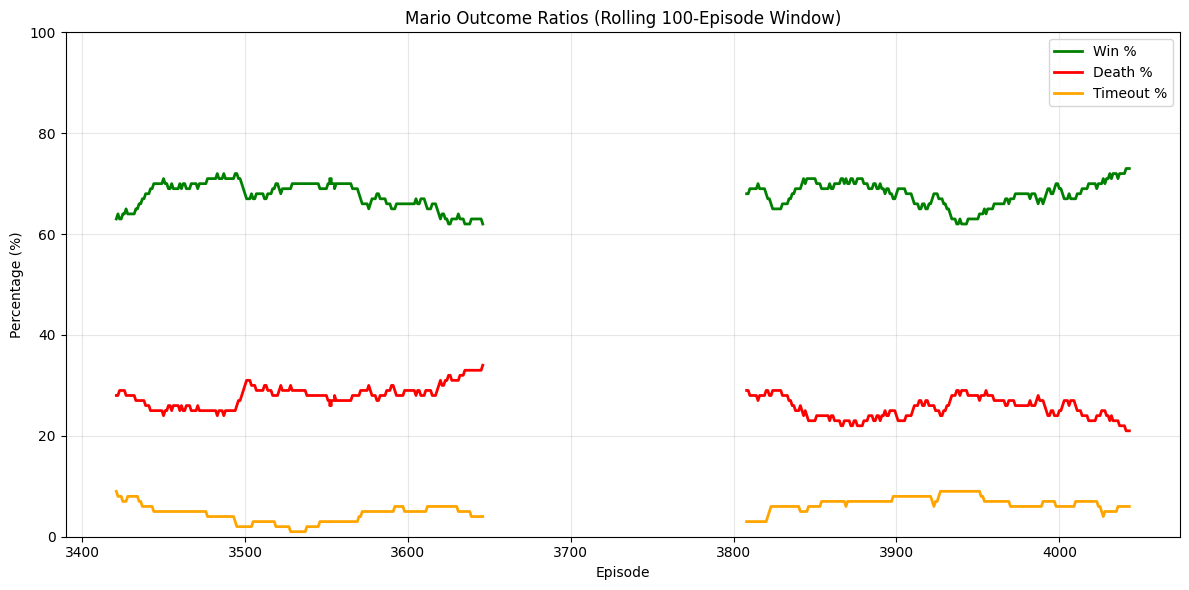


Overall Statistics (667 episodes):
Wins: 448 (67.2%)
Deaths: 181 (27.1%)
Timeouts: 38 (5.7%)


In [22]:
import re
import matplotlib.pyplot as plt

# Read the file
with open('../logs/misc/raw_output.txt', 'r') as f:
    lines = f.readlines()

# Parse outcomes and episodes
episodes = []
outcomes = []  # 'win', 'die', 'timeout'

current_outcome = None
for line in lines:
    line = line.strip()
    
    # Check for outcome
    if 'Mario won!' in line:
        current_outcome = 'win'
    elif 'Mario died!' in line:
        current_outcome = 'die'
    elif 'Time out!' in line:
        current_outcome = 'timeout'
    
    # Check for episode number with reward
    match = re.search(r'Episode (\d+): Reward=', line)
    if match and current_outcome:
        episodes.append(int(match.group(1)) + 1500)
        outcomes.append(current_outcome)
        current_outcome = None

# Find break point (gap larger than 50 episodes)
break_idx = None
for i in range(1, len(episodes)):
    if episodes[i] - episodes[i-1] > 50:
        break_idx = i
        break

# Split data into two batches if break found
if break_idx:
    episodes1 = episodes[:break_idx]
    outcomes1 = outcomes[:break_idx]
    episodes2 = episodes[break_idx:]
    outcomes2 = outcomes[break_idx:]
    batches = [(episodes1, outcomes1), (episodes2, outcomes2)]
else:
    batches = [(episodes, outcomes)]

# Calculate rolling ratios for each batch
window_size = 100
all_win_ratios = []
all_die_ratios = []
all_timeout_ratios = []
all_episode_centers = []

for batch_episodes, batch_outcomes in batches:
    win_ratios = []
    die_ratios = []
    timeout_ratios = []
    episode_centers = []
    
    for i in range(len(batch_outcomes)):
        if i < window_size - 1:
            continue
        
        window = batch_outcomes[i-window_size+1:i+1]
        total = len(window)
        
        win_ratios.append(window.count('win') / total * 100)
        die_ratios.append(window.count('die') / total * 100)
        timeout_ratios.append(window.count('timeout') / total * 100)
        episode_centers.append(batch_episodes[i])
    
    all_win_ratios.append(win_ratios)
    all_die_ratios.append(die_ratios)
    all_timeout_ratios.append(timeout_ratios)
    all_episode_centers.append(episode_centers)

# Plot
plt.figure(figsize=(12, 6))

# Plot each batch separately to show gap
for i, (episodes_batch, win_batch, die_batch, timeout_batch) in enumerate(
    zip(all_episode_centers, all_win_ratios, all_die_ratios, all_timeout_ratios)
):
    label_suffix = '' if i == 0 else ''  # Only label first batch
    plt.plot(episodes_batch, win_batch, linewidth=2, color='green', 
             label='Win %' if i == 0 else '')
    plt.plot(episodes_batch, die_batch, linewidth=2, color='red',
             label='Death %' if i == 0 else '')
    plt.plot(episodes_batch, timeout_batch, linewidth=2, color='orange',
             label='Timeout %' if i == 0 else '')

plt.xlabel('Episode')
plt.ylabel('Percentage (%)')
plt.title(f'Mario Outcome Ratios (Rolling {window_size}-Episode Window)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

# Print overall statistics
print(f"\nOverall Statistics ({len(outcomes)} episodes):")
print(f"Wins: {outcomes.count('win')} ({outcomes.count('win')/len(outcomes)*100:.1f}%)")
print(f"Deaths: {outcomes.count('die')} ({outcomes.count('die')/len(outcomes)*100:.1f}%)")
print(f"Timeouts: {outcomes.count('timeout')} ({outcomes.count('timeout')/len(outcomes)*100:.1f}%)")